In [533]:
# 라이브러리 모음

import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
import copy 
import os 
import torch
import numpy as np
import cv2

from torchvision.models import resnet18, resnet34, resnet50, resnet101, resnet152

from PIL import Image 
from torch.utils.data import Dataset 
import torchvision
import torchvision.transforms as transforms 
from torch.optim.lr_scheduler import ReduceLROnPlateau  
import torch.nn as nn 
from torchvision import utils 
from torchvision.datasets import ImageFolder
from torchsummary import summary
import torch.nn.functional as F
from sklearn.metrics import classification_report
import itertools 
from tqdm.notebook import trange, tqdm 
from torch import optim
import warnings

warnings.filterwarnings('ignore')

In [534]:
IMAGE_SIZE = 256
IMAGE_CHANNEL = 3

In [535]:
class CLAHETransform:
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8)):
        self.clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
        
    def __call__(self, img):
        img = np.array(img)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(img)
        l = self.clahe.apply(l)
        img = cv2.merge((l, a, b))
        img = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)
        return Image.fromarray(img)

class GammaCorrection:
    def __init__(self, gamma=1.0):
        self.gamma = gamma
        
    def __call__(self, img):
        img = np.array(img)
        img = img / 255.0
        img = np.power(img, self.gamma)
        img = np.uint8(img * 255)
        return Image.fromarray(img)

class ErodeTransform:
    def __init__(self, kernel_size=(3, 3), iterations=1):
        self.kernel = np.ones(kernel_size, np.uint8)
        self.iterations = iterations

    def __call__(self, img):
        img = np.array(img)
        img = cv2.erode(img, self.kernel, iterations=self.iterations)
        return Image.fromarray(img)

class DilateTransform:
    def __init__(self, kernel_size=(3, 3), iterations=1):
        self.kernel = np.ones(kernel_size, np.uint8)
        self.iterations = iterations

    def __call__(self, img):
        img = np.array(img)
        img = cv2.diate(img, self.kernel, iterations=self.iterations)
        return Image.fromarray(img)
        
class CropLargestSquareTransform:
    def __call__(self, img):
        img = np.array(img)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray, 0, 127, cv2.THRESH_BINARY)
        
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if not contours:
            return Image.fromarray(img)
        
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        
        side_length = max(w, h)
        x_center = x + w // 2
        y_center = y + h // 2
        x1 = max(x_center - side_length // 2, 0)
        y1 = max(y_center - side_length // 2, 0)
        x2 = min(x_center + side_length // 2, img.shape[1])
        y2 = min(y_center + side_length // 2, img.shape[0])
        
        img_cropped = img[y1:y2, x1:x2]
        return Image.fromarray(img_cropped)
        
class CustomCenterCrop:
    def __call__(self, img):
        width, height = img.size
        new_width, new_height = width // 2, height // 2
        return transforms.functional.center_crop(img, (new_height, new_width))



In [536]:
transform = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.CenterCrop(IMAGE_SIZE/2),                    # 중앙에서 256x256 크기로 잘라내기
        # transforms.RandomHorizontalFlip(p=0.5),
        # transforms.RandomVerticalFlip(p=0.5),
        # transforms.RandomRotation(30),
        # DilateTransform(kernel_size=(3,3), iterations=2),
        # ErodeTransform(kernel_size=(3,3), iterations=1),

        CLAHETransform(clip_limit=5.0, tile_grid_size=(8, 8)),
        # GammaCorrection(gamma=0.45),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

In [537]:
# Define object of the Train, Validation, and Test dataset.
train_set = torchvision.datasets.ImageFolder("archive/train", transform=transform) 
train_set.transform
val_set = torchvision.datasets.ImageFolder("archive/valid", transform=transform)
val_set.transform
test_set = torchvision.datasets.ImageFolder("archive/test", transform=transform)
test_set.transform

Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(128, 128))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

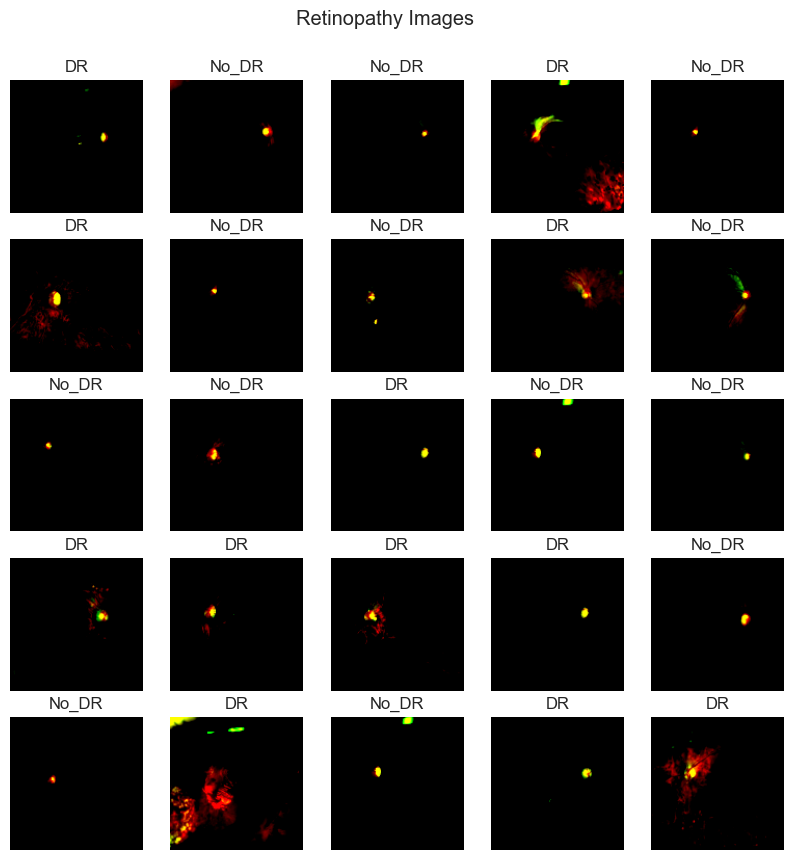

In [542]:
# Visualizing some images from Trainset
CLA_label = {
        0 : 'DR',
        1 : 'No_DR',
}
figure = plt.figure(figsize=(10, 10))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(CLA_label[label])
    plt.axis("off")
    img_np = img.numpy().transpose((1, 2, 0))
    # Clip pixel values to [0, 1]
    img_valid_range = np.clip(img_np, 0, 1)
    plt.imshow(img_valid_range)
    plt.suptitle('Retinopathy Images', y=0.95)
plt.show()

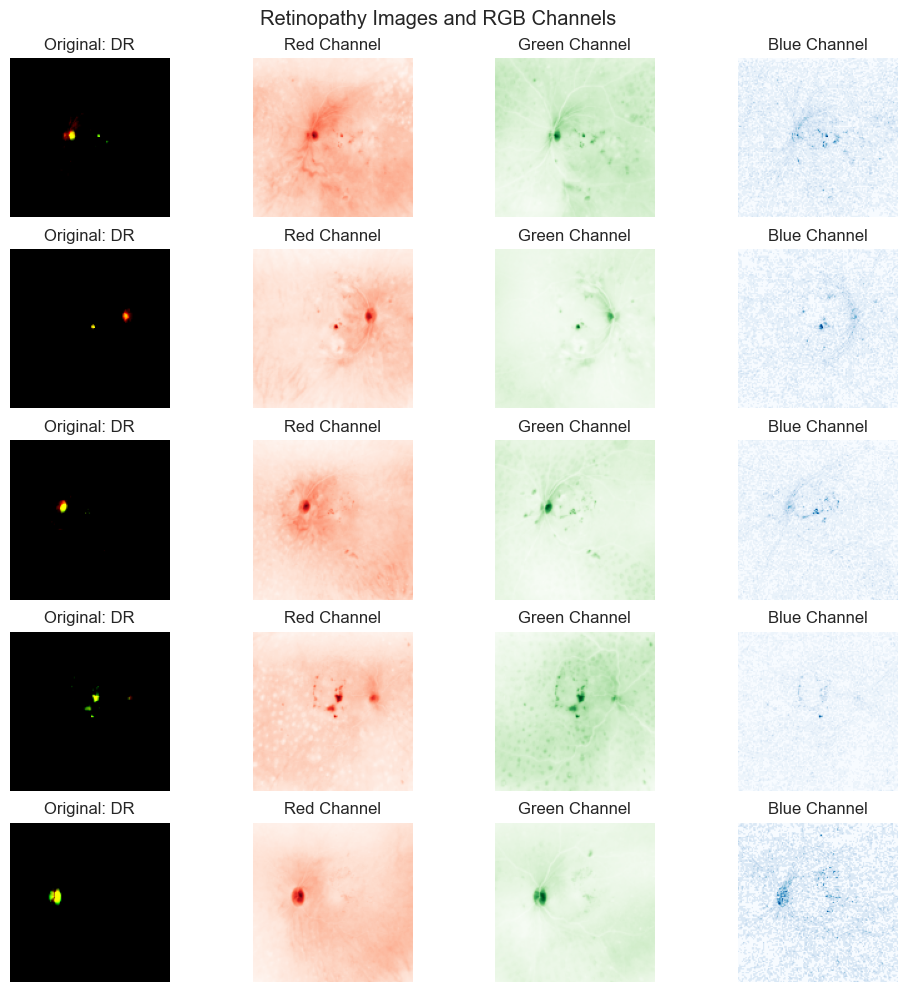

In [546]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# 그리드 크기 설정
rows, cols = 5, 4

# 이미지 그리드 설정
figure = plt.figure(figsize=(12, 12))

for row in range(1, rows + 1):
    # 무작위로 이미지 선택
    # if row == 1:
    #     img, label = train_set[101]
    # elif row == 2:
    #     img, label = train_set[120]
    # elif row == 3:
    #     img, label = train_set[38]
    # elif row == 4 :
    #     img, label = train_set[160]
    # else:
    #     img, label = train_set[100]

    # 무작위로 이미지 선택
    img, label = train_set[row+2*row]

    # 이미지 numpy 배열로 변환
    img_np = img.numpy().transpose((1, 2, 0))

    # 이미지 RGB 채널 분리
    R = img_np[:, :, 0]
    G = img_np[:, :, 1]
    B = img_np[:, :, 2]

    # 각 채널 및 원본 이미지를 시각화
    figure.add_subplot(rows, cols, (row - 1) * cols + 1)
    plt.title(f"Original: {CLA_label[label]}")
    plt.axis("off")
    plt.imshow(np.clip(img_np, 0, 1))

    figure.add_subplot(rows, cols, (row - 1) * cols + 2)
    plt.title("Red Channel")
    plt.axis("off")
    plt.imshow(R, cmap="Reds")

    figure.add_subplot(rows, cols, (row - 1) * cols + 3)
    plt.title("Green Channel")
    plt.axis("off")
    plt.imshow(G, cmap="Greens")

    figure.add_subplot(rows, cols, (row - 1) * cols + 4)
    plt.title("Blue Channel")
    plt.axis("off")
    plt.imshow(B, cmap="Blues")

plt.suptitle('Retinopathy Images and RGB Channels', y=0.92)
plt.show()


In [540]:
# import matplotlib.pyplot as plt
# import numpy as np
# import torch
# from collections import defaultdict

# # 레이블 매핑 사전
# CLA_label = {
#     0: 'DR',
#     1: 'No_DR',
# }

# def compute_mean_images(dataset):
#     # 각 레이블에 대한 이미지 저장 및 카운트 초기화
#     label_images = defaultdict(lambda: {'sum': np.zeros((IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32), 'count': 0})
    
#     for img, label in dataset:
#         img_np = img.numpy().transpose((1, 2, 0))
#         img_np = np.clip(img_np, 0, 1)
        
#         label_images[label]['sum'] += img_np
#         label_images[label]['count'] += 1
    
#     # 평균 이미지 계산
#     mean_images = {}
#     for label, data in label_images.items():
#         mean_images[label] = data['sum'] / data['count']
    
#     return mean_images

# def visualize_mean_images(mean_images, title):
#     figure = plt.figure(figsize=(12, 8))
#     cols, rows = len(mean_images), 1
    
#     for i, (label, img) in enumerate(mean_images.items()):
#         figure.add_subplot(rows, cols, i + 1)
#         plt.title(CLA_label[label])
#         plt.axis("off")
#         plt.imshow(img)
    
#     plt.suptitle(title, y=0.95)
#     plt.show()

# # 평균 이미지 계산 및 시각화
# mean_train_images = compute_mean_images(train_set)
# mean_val_images = compute_mean_images(val_set)
# mean_test_images = compute_mean_images(test_set)

# visualize_mean_images(mean_train_images, 'Mean Images for Training Set')
# visualize_mean_images(mean_val_images, 'Mean Images for Validation Set')
# visualize_mean_images(mean_test_images, 'Mean Images for Test Set')


In [541]:
# import matplotlib.pyplot as plt
# import numpy as np
# import torch
# from collections import defaultdict

# # 레이블 매핑 사전
# CLA_label = {
#     0: 'DR',
#     1: 'No_DR',
# }

# def compute_mean_channel_images(dataset):
#     # 각 레이블에 대한 R, G, B 채널 이미지 저장 및 카운트 초기화
#     channel_images = defaultdict(lambda: {
#         'R': {'sum': np.zeros((IMAGE_SIZE, IMAGE_SIZE), dtype=np.float32), 'count': 0},
#         'G': {'sum': np.zeros((IMAGE_SIZE, IMAGE_SIZE), dtype=np.float32), 'count': 0},
#         'B': {'sum': np.zeros((IMAGE_SIZE, IMAGE_SIZE), dtype=np.float32), 'count': 0}
#     })
    
#     for img, label in dataset:
#         img_np = img.numpy().transpose((1, 2, 0))
#         img_np = np.clip(img_np, 0, 1)
        
#         R, G, B = img_np[:, :, 0], img_np[:, :, 1], img_np[:, :, 2]
        
#         channel_images[label]['R']['sum'] += R
#         channel_images[label]['G']['sum'] += G
#         channel_images[label]['B']['sum'] += B
        
#         channel_images[label]['R']['count'] += 1
#         channel_images[label]['G']['count'] += 1
#         channel_images[label]['B']['count'] += 1
    
#     # 평균 채널 이미지 계산
#     mean_channel_images = {}
#     for label, channels in channel_images.items():
#         mean_channel_images[label] = {
#             'R': channels['R']['sum'] / channels['R']['count'],
#             'G': channels['G']['sum'] / channels['G']['count'],
#             'B': channels['B']['sum'] / channels['B']['count']
#         }
    
#     return mean_channel_images

# def visualize_mean_channel_images(mean_channel_images, title):
#     figure = plt.figure(figsize=(15, 10))
#     labels = sorted(mean_channel_images.keys())
#     rows, cols = len(labels), 3  # 3 columns for R, G, B
    
#     for i, label in enumerate(labels):
#         for j, channel in enumerate(['R', 'G', 'B']):
#             figure.add_subplot(rows, cols, i * cols + j + 1)
#             plt.title(f"{CLA_label[label]} - {channel} Channel")
#             plt.axis("off")
#             plt.imshow(mean_channel_images[label][channel], cmap='gray')
    
#     plt.suptitle(title, y=0.95)
#     plt.show()

# # 평균 채널 이미지 계산 및 시각화
# mean_train_channel_images = compute_mean_channel_images(train_set)
# mean_val_channel_images = compute_mean_channel_images(val_set)
# mean_test_channel_images = compute_mean_channel_images(test_set)

# visualize_mean_channel_images(mean_train_channel_images, 'Mean Channel Images for Training Set')
# visualize_mean_channel_images(mean_val_channel_images, 'Mean Channel Images for Validation Set')
# visualize_mean_channel_images(mean_test_channel_images, 'Mean Channel Images for Test Set')
